In [1]:
machine = "local"
!wandb login

wandb: Currently logged in as: dmykhailov (dmykhailov-kyiv-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Imports


In [2]:
import os
import gc
import logging
import numpy as np
import pandas as pd
from PIL import Image
from typing import cast
from matplotlib import pyplot as plt

import timm
import torch
import torch.nn as nn
import pytorch_lightning as pl
from tqdm import tqdm
from torchvision import transforms

import warnings
from notebooks_config import setup_logging, CustomLogger
from src.BiomassDataset import BiomassDataset
from src.BiomassImprovedCNN import BiomassImprovedCNN
from src.image_transforms import get_transforms
from src.cv import create_folds_with_date_groups
from src.dataloaders import get_fold_loaders, print_fold_loader_info
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger

warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"PyTorch: {torch.__version__}")
print(
    f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Available variables: ['BASE_DIR', 'DATA_DIR', 'Path', 'directory', 'find_project_root', 'project_root', 'sys']
PyTorch: 2.9.1+cu128
Device: NVIDIA GeForce RTX 5050 Laptop GPU


In [3]:
# Fix for deterministic CUDA operations
# os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [4]:
logger = setup_logging(
    level=logging.DEBUG,
    full_color=True,
    include_function=False
)
logger = cast(CustomLogger, logger)
logger.success("Logging configuration test completed.")


[2025-12-18 15:54:42]
SUCCESS: Logging configured successfully ✅

[2025-12-18 15:54:42]
SUCCESS: Logging configuration test completed.


## Configuration


In [5]:
cpu_count = os.cpu_count()
NUM_WORKERS = 0

# Training hyperparameters
LR = 1e-4
EPOCHS = 25
N_FOLDS = 5
GRAD_ACCUM = 4
BATCH_SIZE = 4
DROPOUT_RATE = 0.2
WEIGHT_DECAY = 0.05
HIDDEN_RATIO = 0.5

# Architecture options
USE_SPATIAL_ATTENTION = True
USE_CROSS_ATTENTION = True
FUSION_METHOD = 'gated'  # 'concat', 'gated', 'separate'
SCHEDULER = 'cosine'  # 'cosine', 'plateau'

# Targets
ALL_TARGETS = ['Dry_Clover_g', 'Dry_Dead_g',
               'Dry_Green_g', 'Dry_Total_g', 'GDM_g']
USED_TARGETS = ['Dry_Green_g', 'Dry_Total_g', 'GDM_g']

# Model selection
# Good CNNs for this task:
# - 'tf_efficientnetv2_s.in21k_ft_in1k' (fast, good)
# - 'convnext_base.fb_in22k_ft_in1k' (slower, better)
# - 'swinv2_base_window8_256' (transformer-based, very good)
# - 'seresnextaa101d_32x8d.sw_in12k_ft_in1k_288' (heavy, excellent)
MODEL = 'tf_efficientnetv2_s.in21k_ft_in1k'

PROJECT_NAME = "csiro-image2biomass-prediction"
CHECKPOINTS_DIR = "./kaggle/checkpoints/improved_cnn/"

USE_LOG_TARGET = True

DESCRIPTION = (
    f"{machine}_"
    f"{MODEL.split('.')[0]}_"
    f"train[{N_FOLDS}]Folds_"
    f"{'log_' if USE_LOG_TARGET else ''}"
    f"fusion-{FUSION_METHOD}_"
    f"{'spatial_' if USE_SPATIAL_ATTENTION else ''}"
    f"{'cross_' if USE_CROSS_ATTENTION else ''}"
    f"epochs{EPOCHS}_bs{BATCH_SIZE}_gradacc{GRAD_ACCUM}_"
    f"lr{LR}_wd{WEIGHT_DECAY}_dr{DROPOUT_RATE}_hr{HIDDEN_RATIO}"
)

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
pl.seed_everything(SEED)

print("DESCRIPTION:", DESCRIPTION)
print(f"Effective batch size: {BATCH_SIZE * GRAD_ACCUM}")

Seed set to 42


DESCRIPTION: local_tf_efficientnetv2_s_train[5]Folds_log_fusion-gated_spatial_cross_epochs25_bs4_gradacc4_lr0.0001_wd0.05_dr0.2_hr0.5
Effective batch size: 16


In [6]:
# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
print('NUM_WORKERS:', NUM_WORKERS)
print()

if DEVICE.type == 'cuda':
    torch.cuda.empty_cache()
    gc.collect()
    torch.set_float32_matmul_precision('high') if machine == "local" else None

    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3, 1), 'GB')
    print('Cached:', round(torch.cuda.memory_reserved(0)/1024**3, 1), 'GB')

Using device: cuda
NUM_WORKERS: 0

NVIDIA GeForce RTX 5050 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached: 0.0 GB


## Data Loading


In [7]:
PATH_DATA = './kaggle/input/csiro-biomass'
PATH_TRAIN_CSV = os.path.join(PATH_DATA, 'train.csv')
PATH_TEST_CSV = os.path.join(PATH_DATA, 'test.csv')
PATH_TRAIN_IMG = os.path.join(PATH_DATA, 'train')
PATH_TEST_IMG = os.path.join(PATH_DATA, 'test')

df = pd.read_csv(PATH_TRAIN_CSV)
df = df[df['target_name'].isin(USED_TARGETS)].reset_index(drop=True)
print(f"Dataset size: {df.shape}")
display(df.head())

# Pivot to get one row per image
df_pivoted = df.pivot_table(
    index=['image_path', 'Sampling_Date', 'State', 'Species'],
    columns='target_name',
    values='target'
).reset_index()

print(f"\nPivoted dataset: {df_pivoted.shape}")
display(df_pivoted.head())

Dataset size: (1071, 9)


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2750
1,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
2,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750
3,ID1012260530__Dry_Green_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Green_g,7.6000
4,ID1012260530__Dry_Total_g,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,Dry_Total_g,7.6000



Pivoted dataset: (357, 7)


target_name,image_path,Sampling_Date,State,Species,Dry_Green_g,Dry_Total_g,GDM_g
0,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,16.2750,48.2735,16.2750
1,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,10.5261,34.1844,10.9605


## Model Configuration


In [8]:
from timm.data.config import resolve_data_config

config = resolve_data_config({}, model=MODEL)
input_size = int(config['input_size'][1])
mean = config['mean']
std = config['std']

print("Model config:")
print(f"  Input size: {config['input_size']}")
print(f"  Mean: {mean}")
print(f"  Std: {std}")

Model config:
  Input size: (3, 224, 224)
  Mean: (0.485, 0.456, 0.406)
  Std: (0.229, 0.224, 0.225)


In [9]:
train_transforms, valid_transforms = get_transforms(input_size, mean, std)

## Visualize Augmentations


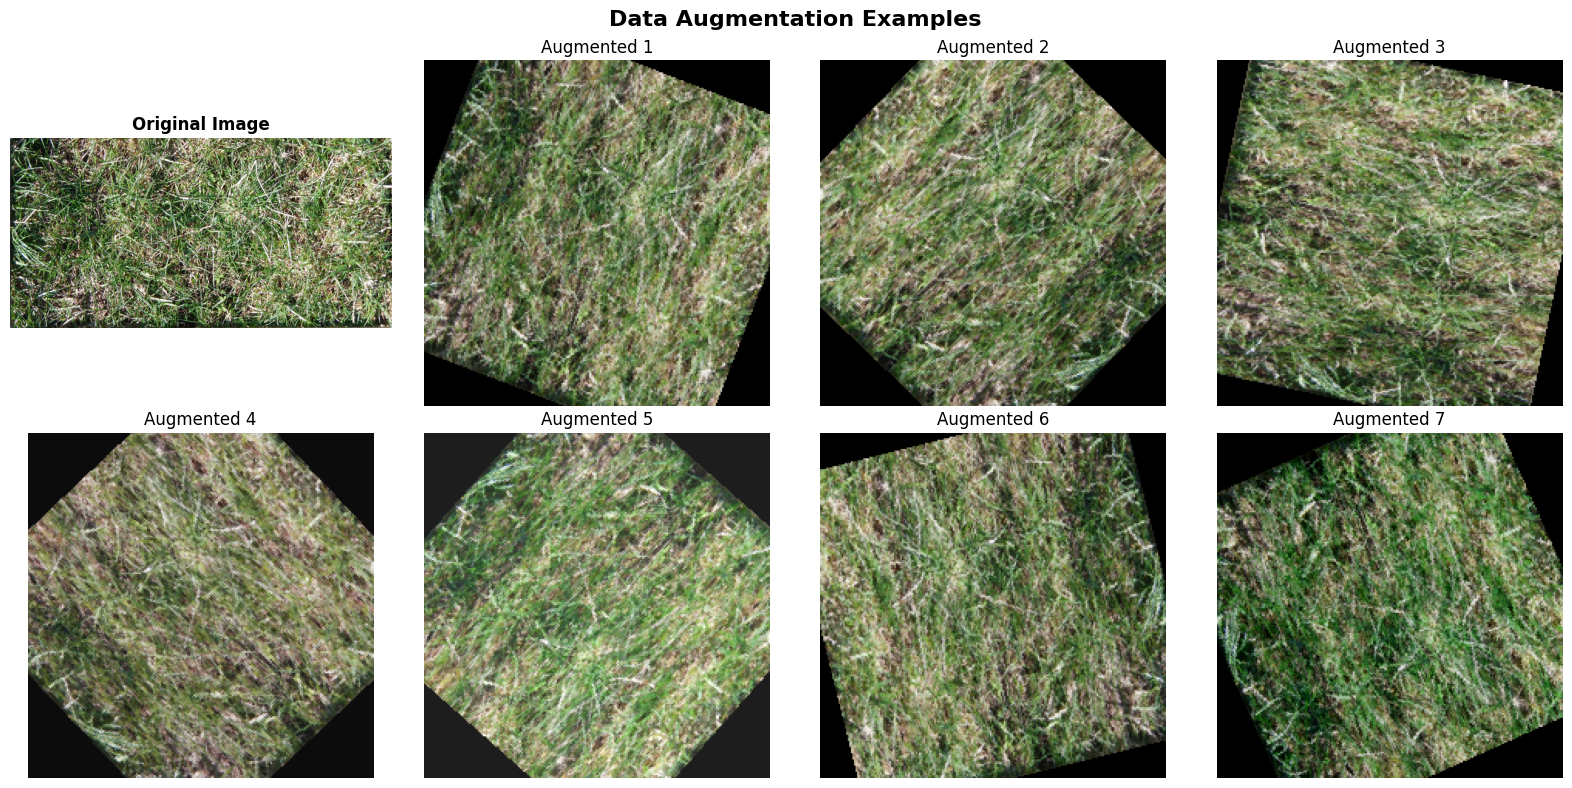

In [10]:
# Get sample image
sample_idx = 0
original_img_path = PATH_DATA + "/" + str(df_pivoted.loc[sample_idx, 'image_path'])
original_img = Image.open(original_img_path).convert('RGB')

# Show augmentations
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

axes[0].imshow(original_img)
axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

for i in range(1, 8):
    augmented = train_transforms(original_img)
    if not isinstance(augmented, torch.Tensor):
        augmented = transforms.ToTensor()(augmented)

    augmented = augmented.to(DEVICE)
    mean_temp = torch.tensor(mean).view(3, 1, 1).to(DEVICE)
    std_temp = torch.tensor(std).view(3, 1, 1).to(DEVICE)
    img_denorm = augmented * std_temp + mean_temp
    img_denorm = torch.clamp(img_denorm, 0, 1)
    img_np = img_denorm.cpu().permute(1, 2, 0).numpy()

    axes[i].imshow(img_np)
    axes[i].set_title(f'Augmented {i}', fontsize=12)
    axes[i].axis('off')

plt.suptitle('Data Augmentation Examples', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Create Folds


In [11]:
df_with_folds = create_folds_with_date_groups(
    df_pivoted,
    n_folds=N_FOLDS,
    use_mass_stratification=True,
    n_mass_bins=5,
    mass_col='Dry_Total_g',
    random_state=SEED
)

print("\nFold distribution:")
print(df_with_folds['fold'].value_counts().sort_index())


Fold 0:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 1:
  Train samples: 282
  Val samples: 75
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 2:
  Train samples: 285
  Val samples: 72
  ✓ No date overlap (train: 21 dates, val: 7 dates)

Fold 3:
  Train samples: 297
  Val samples: 60
  ✓ No date overlap (train: 24 dates, val: 4 dates)

Fold 4:
  Train samples: 279
  Val samples: 78
  ✓ No date overlap (train: 22 dates, val: 6 dates)
FOLD QUALITY VERIFICATION

Fold 0:
  Samples: 72
  State distribution:
    Tas: 52.8%
    Vic: 34.7%
    NSW: 12.5%
  Species distribution:
    Ryegrass_Clover: 37.5%
    Clover: 15.3%
    Ryegrass: 13.9%
    Fescue: 12.5%
    Phalaris_Ryegrass_Clover: 9.7%
    Phalaris_Clover: 8.3%
    Mixed: 2.8%
  Season distribution:
    Winter: 59.7%
    Spring: 27.8%
    Summer: 12.5%
  Mass bin distribution:
    mass_bin_0: 25.0%
    mass_bin_1: 22.2%
    mass_bin_2: 19.4%
    mass_bin_3: 16.7%
    mass_b

## Competition Metric


In [12]:
labels = ["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"]

weights = {
    'Dry_Clover_g': 0.1,
    'Dry_Dead_g': 0.1,
    'Dry_Green_g': 0.1,
    'Dry_Total_g': 0.5,
    'GDM_g': 0.2,
}


def competition_metric(y_true, y_pred) -> float:
    """Calculate competition's weighted R2 score."""
    weights_array = np.array([weights[l] for l in labels])

    y_weighted_mean = np.average(y_true, weights=weights_array, axis=1).mean()

    ss_res = np.average((y_true - y_pred)**2,
                        weights=weights_array, axis=1).mean()
    ss_tot = np.average((y_true - y_weighted_mean)**2,
                        weights=weights_array, axis=1).mean()

    return 1 - ss_res / ss_tot

## Test Model Architecture


In [13]:
# Create dataset
train_dataset = BiomassDataset(
    df=df_pivoted,
    target_cols=USED_TARGETS,
    img_dir=PATH_TRAIN_IMG,
    transform=train_transforms,
    is_test=False,
    use_log_target=USE_LOG_TARGET
)

print(f"Dataset length: {len(train_dataset)}")

# Test sample
sample = train_dataset[0]
print(f"Left image shape: {sample['left_image'].shape}")
print(f"Right image shape: {sample['right_image'].shape}")
print(f"Targets shape: {sample['targets'].shape}")
print(f"Target values: {sample['targets']}")

Dataset length: 357
Left image shape: torch.Size([3, 224, 224])
Right image shape: torch.Size([3, 224, 224])
Targets shape: torch.Size([3])
Target values: tensor([2.8493, 3.8974, 2.8493])


In [14]:
# Create model
model = BiomassImprovedCNN(
    kaggle_score=competition_metric,
    backbone_name=MODEL,
    backbone_input_size=input_size,
    lr=LR,
    weight_decay=WEIGHT_DECAY,
    hidden_ratio=HIDDEN_RATIO,
    dropout=DROPOUT_RATE,
    use_log_target=USE_LOG_TARGET,
    freeze_backbone=True,
    use_spatial_attention=USE_SPATIAL_ATTENTION,
    use_cross_attention=USE_CROSS_ATTENTION,
    fusion_method=FUSION_METHOD,
    scheduler=SCHEDULER
)
model.to(DEVICE)

print("\n" + "="*80)
print("MODEL ARCHITECTURE")
print("="*80)
print(model)
print("\n" + "="*80)

# Test forward pass
with torch.no_grad():
    test_batch = {
        'left_image': sample['left_image'].unsqueeze(0).to(DEVICE),
        'right_image': sample['right_image'].unsqueeze(0).to(DEVICE),
        'targets': sample['targets'].unsqueeze(0).to(DEVICE)
    }
    output = model(test_batch['left_image'], test_batch['right_image'])
    print(f"\nTest forward pass successful!")
    print(f"Output shape: {output['prediction'].shape}")
    print(f"Prediction: {output['prediction']}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel()
                       for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


MODEL ARCHITECTURE
BiomassImprovedCNN(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(3, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Id

## Training Loop


In [ ]:
fold_results = []

for fold_id in range(N_FOLDS):
    print(f"TRAINING FOLD {fold_id}/{N_FOLDS-1}")

    # Get data loaders
    train_loader, val_loader = get_fold_loaders(
        df=df_with_folds,
        dataset=train_dataset,
        fold=fold_id,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS
    )

    print_fold_loader_info(df_with_folds, fold_id, train_loader, val_loader)

    # Create model
    model = BiomassImprovedCNN(
        kaggle_score=competition_metric,
        backbone_name=MODEL,
        backbone_input_size=input_size,
        lr=LR,
        weight_decay=WEIGHT_DECAY,
        hidden_ratio=HIDDEN_RATIO,
        dropout=DROPOUT_RATE,
        use_log_target=USE_LOG_TARGET,
        freeze_backbone=True,
        use_spatial_attention=USE_SPATIAL_ATTENTION,
        use_cross_attention=USE_CROSS_ATTENTION,
        fusion_method=FUSION_METHOD,
        scheduler=SCHEDULER
    )
    model.to(DEVICE)

    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        monitor='val/r2_score',
        dirpath=os.path.join(CHECKPOINTS_DIR, f'fold{fold_id}'),
        filename=f'{DESCRIPTION}-fold{fold_id}' +
        '-{epoch:02d}-{val/r2_score:.4f}',
        save_top_k=2,
        mode='max'
    )

    early_stopping_callback = EarlyStopping(
        monitor='val/r2_score',
        patience=7,
        mode='max',
        verbose=True,
        min_delta=1e-4
    )

    lr_monitor = LearningRateMonitor(logging_interval='epoch')

    # Logger
    wandb_logger = WandbLogger(
        project=PROJECT_NAME,
        name=f'{DESCRIPTION[:100]}-fold{fold_id}',
        log_model='all',
        tags=['ImprovedCNN', f'fold{fold_id}',
              FUSION_METHOD, MODEL.split('.')[0]]
    )

    # Trainer
    trainer = pl.Trainer(
        max_epochs=EPOCHS,
        accelerator=DEVICE.type,
        precision='16-mixed' if torch.cuda.is_available() else 32,
        accumulate_grad_batches=GRAD_ACCUM,
        callbacks=[checkpoint_callback, early_stopping_callback, lr_monitor],
        logger=wandb_logger,
        log_every_n_steps=1,
        gradient_clip_val=1.0,
        gradient_clip_algorithm='norm',
        enable_progress_bar=True,
        # deterministic=True,
        num_sanity_val_steps=0,
    )

    try:
        # Train
        trainer.fit(model, train_loader, val_loader)

        # Load best checkpoint
        best_model_path = checkpoint_callback.best_model_path
        logger.info(f"Loading best model from: {best_model_path}")
        best_model = BiomassImprovedCNN.load_from_checkpoint(best_model_path)

        # Evaluate
        val_result = trainer.validate(best_model, val_loader, verbose=False)
        fold_results.append({
            'fold': fold_id,
            'val/loss': val_result[0]['val/loss'],
            'val/r2_score': val_result[0]['val/r2_score']
        })

        logger.success(
            f"Fold {fold_id} completed! R2: {val_result[0]['val/r2_score']:.4f}")

    except SystemExit:
        logger.warning(
            f"Training interrupted during fold {fold_id}. Exiting gracefully.")
        wandb_logger.experiment.finish()
        del model, trainer, wandb_logger, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()
        break

    finally:
        wandb_logger.experiment.finish()
        del model, trainer, wandb_logger, train_loader, val_loader
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.synchronize() if torch.cuda.is_available() else None

TRAINING FOLD 0/4

Fold 0 DataLoaders Info:
  Train samples: 285
  Val samples: 72
  Train batches: 72
  Val batches: 18
  Train batch size: 4
  Val batch size: 4


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: Currently logged in as: dmykhailov (dmykhailov-kyiv-school-of-economics) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:242: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name             | Type               | Params | Mode  | FLOPs
------------------------------------------------------------------------
0 | backbone         | EfficientNet       | 20.2 M | train | 0    
1 | spatial_attn     | SpatialAttention   | 205 K  | train | 0    
2 | multi_scale_pool | MultiScalePooling  | 0      | train | 0    
3 | projection       | Sequential         | 6.6 M  | train | 0    
4 | cross_attn       | CrossViewAttention | 2.1 M  | train | 0    
5 | gate_left        | Sequential         | 262 K  | train | 0    
6 | gate_right       | Sequential         | 262 K  | train | 0    
7 | head             | RegressionHead     | 794 K  | train | 0    
--------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

c:\_GitHub\CSIRO-Image2Biomass-Prediction\.venv\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/r2_score improved. New best score: -0.105


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/r2_score improved by 0.300 >= min_delta = 0.0001. New best score: 0.195


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/r2_score improved by 0.197 >= min_delta = 0.0001. New best score: 0.392


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/r2_score improved by 0.081 >= min_delta = 0.0001. New best score: 0.473


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val/r2_score improved by 0.092 >= min_delta = 0.0001. New best score: 0.564


In [ ]:
results_df = pd.DataFrame(fold_results)
print(results_df)
print(
    f"\nMean Val Loss: {results_df['val/loss'].mean():.4f} ± {results_df['val/loss'].std():.4f}")
print(
    f"Mean R2 Score: {results_df['val/r2_score'].mean():.4f} ± {results_df['val/r2_score'].std():.4f}")

## Inference Example


In [ ]:
# Load best model from fold 0 for inference example
import glob
fold_id = 0
checkpoint_path = os.path.join(CHECKPOINTS_DIR, f'fold{fold_id}')

checkpoints = glob.glob(os.path.join(checkpoint_path, '*.ckpt'))
if checkpoints:
    best_ckpt = max(checkpoints, key=lambda x: float(
        x.split('val/r2_score=')[-1].split('.ckpt')[0]))
    print(f"Loading checkpoint: {best_ckpt}")

    inference_model = BiomassImprovedCNN.load_from_checkpoint(best_ckpt)
    inference_model.to(DEVICE)
    inference_model.eval()

    # Test on validation sample
    val_loader, _ = get_fold_loaders(
        df_with_folds, train_dataset, fold_id, BATCH_SIZE)
    batch = next(iter(val_loader))

    with torch.no_grad():
        preds = inference_model.predict_step(
            {k: v.to(DEVICE)
             for k, v in batch.items() if isinstance(v, torch.Tensor)},
            0
        )

    print(f"\nPredictions shape: {preds.shape}")
    print(f"First 5 predictions:\n{preds[:5]}")
    print(
        f"\nFirst 5 targets (original scale):\n{torch.expm1(batch['targets'][:5]) if USE_LOG_TARGET else batch['targets'][:5]}")
else:
    print("No checkpoints found!")